1. Необходимо решить задачу классификации, используя данные из файла train.csv

В файле 300000 строк, содержащих:
- id пользователя,
- target - класс пользователя, который модель должна научиться прогнозировать,
- c_0 ... c_68 - признаки, характеризующие пользователя.
    
В решении нужно пройти все стандартные этапы построения модели:
1. Анализ данных
2. Предобработка данных
3. Разделить данные на обучение и валидацию
4. Обучить модель
5. Оценить метрики
6. Сделать выводы

Рекомендуется использовать описание, позволяющие понять вашу логику и ход выполнения задачи.
Приветсвуются графики, применение различных подходов, хорошее качество кода.    

2. Решите задачу вторым способом с использованием инновационного подхода, приложите ссылку на его описание, сравните с первоначальным решением, сделайте выводы.
Если подходящих идей на примете нет, можно использовать статью:  
Focal loss implementation for LightGBM https://maxhalford.github.io/blog/lightgbm-focal-loss/  
Написать, какой получился эффект от применения, как подбирались параметры.
    
3. Напишите скоринг получившейся модели с помощью spark, с целью сокращения времени скоринга на миллионах записей.  
Для этого предлагается использовать google colab https://colab.research.google.com, пример создания spark сессии приложен в файле PySpark.ipynb.  
Можно проскорить только sample файла.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(rc={'figure.figsize':(15,10)})

# Exploratory Data Analysis

In [3]:
df = pd.read_csv('train.csv')
print("Размерность данных - ", df.shape)

Размерность данных -  (300000, 71)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 71 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   target  300000 non-null  int64  
 2   c_0     158574 non-null  float64
 3   c_1     268104 non-null  object 
 4   c_2     174055 non-null  float64
 5   c_3     300000 non-null  object 
 6   c_4     300000 non-null  int64  
 7   c_5     300000 non-null  object 
 8   c_6     300000 non-null  object 
 9   c_7     300000 non-null  int64  
 10  c_8     300000 non-null  int64  
 11  c_9     300000 non-null  int64  
 12  c_10    300000 non-null  float64
 13  c_11    300000 non-null  object 
 14  c_12    278878 non-null  object 
 15  c_13    300000 non-null  object 
 16  c_14    300000 non-null  int64  
 17  c_15    299906 non-null  float64
 18  c_16    300000 non-null  object 
 19  c_17    278878 non-null  float64
 20  c_18    278878 non-null  object 
 21  c_19    27

In [5]:
df.head(10)

,id,target,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,...,c_59,c_60,c_61,c_62,c_63,c_64,c_65,c_66,c_67,c_68
0,0,0,0.8,"60,0000000000",0.0,"1,02136290152217",61,"0,4961666866","773,266666666667",-1034,...,0.000000,"0,0109016044229545","0,39","7,88888888888889","6,2105",0.000000,NaN,"15,5",NaN,2
1,1,0,NaN,"795,0000000000",0.0,"0,951475264778514",796,"0,3956735027","2639,16666666667",-2527,...,0.000000,"0,00432523750887058","0,66","2,37777777777778","7,7273",0.000000,NaN,15,NaN,4
2,2,1,NaN,"60,0000000000",NaN,"0,99988002687398",61,"0,8216901553",0,-1034,...,0.041783,"0,0131991958087561","0,00","6,61111111111111","9,7619",1.333333,NaN,13,NaN,2
3,3,0,NaN,"52,0000000000",0.0,"0,581632653061224",53,"0,4237069155","3577,06666666667",-1034,...,0.000000,"0,00235103871497875","0,66","3,57777777777778","7,2000",0.000000,NaN,"15,5",NaN,4
4,4,0,NaN,"30,0000000000",0.0,"5,79993040089983E-06",61,"0,4898688295","0,0666666666666667",-1034,...,0.086351,"-7,78275749974827E-05","0,00","10,3333333333333","2,7647",0.000000,NaN,"15,5",NaN,2
5,5,0,0.2,"23,0000000000",NaN,"0,999996284855486",10,"0,4388398238","133,6",-1034,...,0.000000,"0,0109840047850247","0,28","5,27777777777778","7,4737",0.000000,NaN,4,NaN,2
6,6,0,NaN,"56,0000000000",2.0,"0,999981800222037",57,"0,4635223845","956,966666666667",-1030,...,0.000000,"0,00432125834982328","0,32","9,98888888888889","59,0000",0.000000,NaN,14,NaN,3
7,7,0,NaN,NaN,NaN,"0,249999676282213",61,"0,3972425075",0,-1002,...,0.047354,"0,0112352735528293","0,00","7,35555555555556","26,0000",1.416667,NaN,"15,5",NaN,2
8,8,0,NaN,"52,0000000000",1.0,"0,337699034415271",53,"0,4527762075","1580,5",-1034,...,0.000000,"0,00432504583368607","0,54","7,32222222222222","29,0000",0.000000,NaN,"14,5",NaN,5
9,9,0,NaN,NaN,0.0,"0,950913877164618",31,"0,0000000000","0,266666666666667",-1034,...,0.000000,"-0,0142384098311539","0,50","4,35555555555556","13,6667",0.000000,NaN,"1,66666666666667",NaN,1


Как мы можем видеть описание пользователя содержит преимущественно числовые признаки и несколько текстовых (категорийных). Необходимо:  
1. выполнить преобразование атрибутов типа 'object' к соответствующему типу данных
2. Заполнить пропуски в данных

In [6]:
string_cols = ['c_16', 'c_41', 'c_54', 'c_67']

In [7]:
# обработка атрибутов типа 'object'
for i in df.columns:
    if (df.dtypes[i] == 'object') & (i not in string_cols):
        df[i] = df[i].str.replace(',', '.').astype(float)
    elif (df.dtypes[i] == 'object') & (i in string_cols):
        df[i] = df[i].astype('string')

### Заполнение пропусков в данных

Для вещественных атрибутов заполним пропуски средними значениями, для текстовых - введем дополнительное значение 'NA'

In [8]:
for i in df.select_dtypes(include=['float64']):
    df[i] = df[i].fillna(df[i].mean())

In [9]:
df.c_54 = df.c_54.fillna('NA')
df.c_67 = df.c_67.fillna('NA')

### Анализ отдельных признаков

Посмотрим распределение целевой переменной

<AxesSubplot:xlabel='target', ylabel='count'>

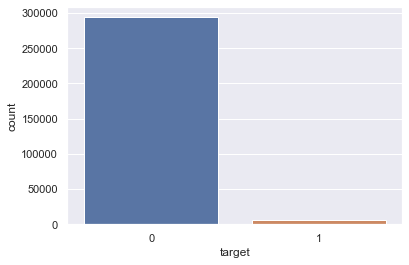

In [10]:
sns.countplot(df.target)

In [11]:
df[['id', 'target']].groupby('target').count().iloc[1] / df[['id', 'target']].groupby('target').count().iloc[0] * 100

id    2.005427
dtype: float64

**В распределении целевой переменной присутствует существенный дисбаланс: доля целевого класса составляет 2%**

Проанализируем распределение по нескольким атрибутом

<AxesSubplot:xlabel='c_0', ylabel='count'>

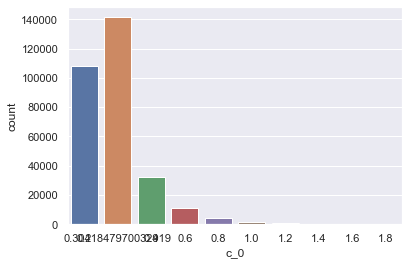

In [12]:
# построим график распределения для атрибута 'c_0'
sns.countplot(x='c_0', data=df.loc[df.c_0 < 2])

In [13]:
print('c_0 mean - ', df.c_0.mean())
print('c_0 median - ', df.c_0.median())

c_0 mean -  0.3041847970032919
c_0 median -  0.3041847970032919


<AxesSubplot:xlabel='target', ylabel='c_0'>

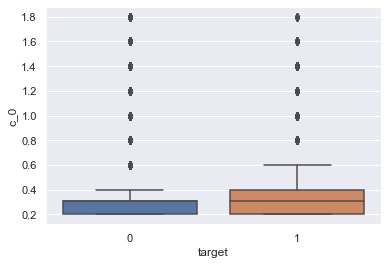

In [14]:
# проанализируем распределение переменной c_0 в зависимости от target
sns.boxplot(x="target", y="c_0", data=df.loc[df.c_0 < 2])

График показывает, что распределенние значений признака существенно варьируется для целевых классов. То есть данный признак может быть значимым для построения классификационной модели

Проведем аналогичный анализ для атрибута c_1

<AxesSubplot:xlabel='target', ylabel='c_1'>

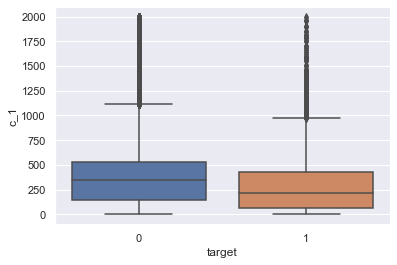

In [15]:
sns.boxplot(x="target", y="c_1", data=df.loc[df.c_1 < 2000])

Для текстовых атрибутов, на примере распределения значений атрибута "с_4" с группировкой по значениям атрибута "с_54"

<AxesSubplot:xlabel='c_54', ylabel='c_4'>

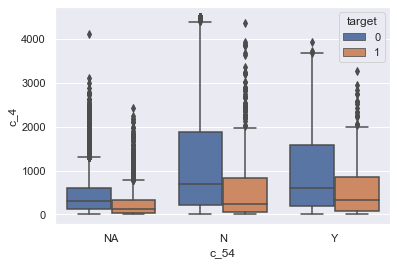

In [16]:
sns.boxplot(x="c_54", y="c_4", hue='target', data=df)

**Беглый анализ нескольких атрибутов в данных позволяет сделать предварительные выводы, о том что в признаках имеется положительный сигнал, позволяющий разделить объекты целевых классов. В рамках более детальной проработки задачи целесообразно провести ряд статистических тестов для оценки отличия в распределении значений целевых переменных**

In [17]:
corr = df.corr()

<AxesSubplot:>

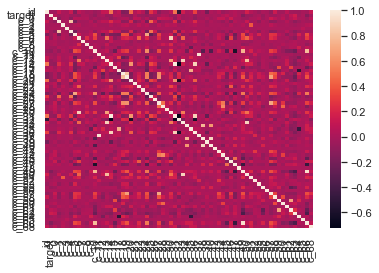

In [18]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [19]:
s = corr.unstack()
so = s.sort_values(kind="quicksort")

In [20]:
len(so)

4489

In [21]:
so[4400:4420]

c_19  c_18    0.801301
c_18  c_19    0.801301
c_1   c_4     0.818778
c_4   c_1     0.818778
c_30  c_6     0.879185
c_6   c_30    0.879185
c_33  c_13    0.880329
c_13  c_33    0.880329
c_31  c_36    0.884105
c_36  c_31    0.884105
c_14  c_36    0.889003
c_36  c_14    0.889003
c_50  c_33    0.892773
c_33  c_50    0.892773
c_40  c_38    0.910830
c_38  c_40    0.910830
c_66  c_49    0.950643
c_49  c_66    0.950643
c_37  c_11    0.965762
c_11  c_37    0.965762
dtype: float64

В датасете присутствуют определенные пары атрибутов, характеризующиеся высокой степенью корреляции. Потенциально данные часть скоррелированных признаков можно убрать для датасета  
В случае применения линейных моделей необходимо убрать коллинеарные признаки, для моделей на основе решающих деревьев данная процедура также является желательной - позволит сократить время на построение оптимальной модели и инференс модели при эксплуатации.

# Построение модели

#### Для построения классификационной модели будут использованы следующие решения:
1. Классификатор LightGBM (градиентный бустинг)
2. Классификатор LightGBM + Focal Loss (предложенный в заданий)
3. Построение модели классификации с использованием глубоких нейронных сетей (TabNet)

# LightGBM with LogLoss and Focal Loss

In [22]:
import lightgbm as lgb
import numpy as np
from scipy import optimize
from scipy import special
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [23]:
categorical_columns = []
categorical_dims =  {}
data = df.iloc[:, 2:]
target = df.target
for col in data.columns[data.dtypes == 'string']:
    print(col, data[col].nunique())
    l_enc = LabelEncoder()
    data[col] = l_enc.fit_transform(data[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

c_16 2330
c_41 7
c_54 3
c_67 97


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    data, target,
    random_state=42
)
X_fit, X_val, y_fit, y_val = train_test_split(
    X_train, y_train,
    random_state=42
)

In [25]:
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'auc',
            'verbose': -1,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

In [26]:
clf = lgb.LGBMClassifier(num_leaves= 15, max_depth=5, 
                         verbose=0, 
                         metric='AUC', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)

In [27]:
params = {'n_estimators': [500],
         'num_leaves': [3, 5],
          'max_depth': [3, 5],
         }

In [28]:
grid = GridSearchCV(clf, params)

In [29]:
grid.fit(data, target)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

GridSearchCV(estimator=LGBMClassifier(colsample_bytree=0.9, max_depth=5,
                                      metric='AUC', n_estimators=1000, n_jobs=4,
                                      num_leaves=15, subsample=0.9, verbose=0),
             param_grid={'max_depth': [3, 5], 'n_estimators': [500],
                         'num_leaves': [3, 5]})

In [30]:
grid.best_score_

0.8767833333333334

In [31]:
grid.best_params_

{'max_depth': 3, 'n_estimators': 500, 'num_leaves': 3}

Проведем эксперимент, описанный в статье с использованием функции потерь FocalLoss

In [32]:
class FocalLoss:

    def __init__(self, gamma, alpha=None):
        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds

    def lgb_obj(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        return self.grad(y, p), self.hess(y, p)

    def lgb_eval(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        is_higher_better = False
        return 'focal_loss', self(y, p).mean(), is_higher_better

In [33]:
fl = FocalLoss(alpha=None, gamma=0)

In [34]:
fit = lgb.Dataset(
    X_fit, y_fit,
    init_score=np.full_like(y_fit, fl.init_score(y_fit), dtype=float)
)

val = lgb.Dataset(
    X_val, y_val,
    init_score=np.full_like(y_val, fl.init_score(y_fit), dtype=float),
    reference=fit
)

In [35]:
model = lgb.train(
    params={'learning_rate': 0.01},
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=20,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13578
[LightGBM] [Info] Number of data points in the train set: 168750, number of used features: 69
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 20 rounds
[100]	fit's focal_loss: 0.0710532	val's focal_loss: 0.074728
[200]	fit's focal_loss: 0.0648064	val's focal_loss: 0.0710355
[300]	fit's focal_loss: 0.0609738	val's focal_loss: 0.0697239
[400]	fit's focal_loss: 0.0580466	val's focal_loss: 0.0691809
[500]	fit's focal_loss: 0.0553923	val's focal_loss: 0.0689491
[600]	fit's focal_loss: 0.0532079	val's focal_loss: 0.0688221
Early stopping, best iteration is:
[658]	fit's focal_loss: 0.0521113	val's focal_loss: 0.0688002


In [36]:
y_pred = special.expit(model.predict(X_test))

In [37]:
print()
print(f"Test's ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.5f}")


Test's ROC AUC: 0.88146


**Результаты проведенного эксперимента показывают, что с исзменением функции потерь с LogLoss на FocalLoss удается добиться повышения метрики качества ROC-AUC с 0.8768 до 0.88146**

In [38]:
model.save_model("model.txt")

In [39]:
data.to_csv("train_processed.csv")

# Tabnet classifier

Проведем эксперимент с использованием классификатора на базе глубокой нейронной сети (архитектура TabNet), архитектура сети описана в статье https://arxiv.org/abs/1908.07442

In [40]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.model_selection import train_test_split

In [41]:
features = [ col for col in data.columns]

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [42]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=10,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

Device used : cpu


In [43]:
train_val_indices, test_indices = train_test_split(
    range(len(data)), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

In [44]:
X_train = data[features].values[train_indices]
y_train = target.values[train_indices]

X_valid = data[features].values[valid_indices]
y_valid = target.values[valid_indices]

X_test = data[features].values[test_indices]
y_test = target[target].values[test_indices]

In [45]:
X_train.shape

(159999, 69)

In [46]:
X_valid.shape

(80001, 69)

In [47]:
X_test.shape

(60000, 69)

In [51]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=5, patience=100,
    batch_size=16384, virtual_batch_size=256
)

epoch 0  | loss: 0.09652 | train_auc: 0.74977 | valid_auc: 0.75263 |  0:01:43s
epoch 1  | loss: 0.08731 | train_auc: 0.72264 | valid_auc: 0.7199  |  0:03:24s
epoch 2  | loss: 0.08654 | train_auc: 0.76222 | valid_auc: 0.75869 |  0:05:04s
epoch 3  | loss: 0.08429 | train_auc: 0.77886 | valid_auc: 0.77658 |  0:06:43s
epoch 4  | loss: 0.08328 | train_auc: 0.78529 | valid_auc: 0.78605 |  0:08:23s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_auc = 0.78605
Best weights from best epoch are automatically used!


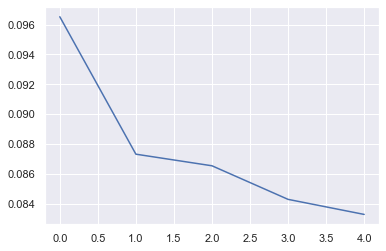

In [52]:
plt.plot(clf.history['loss'])

В результате более длительного ранее проведенного эксперимента по обучению модели были получены значения ROC-AUC ~0.825, что существенно ниже по качеству чем модели на основе градиентного бустинга

**Выводы:**  
1. Были проведены эксперименты по обучению классификатора с использованием моделей LightGBM с различными функциями потерь и TabNet
2. Наилучшие результаты показала модель LightGBM с функцией потерь FocalLoss (ROC-AUC = 0.881). Данная функция потерь является более оптимальной для построения модели на сильно несбалансированных данных (доля целевого класса ~ 2%), так как позволяет более уверенно распознавать примеры сложных объектов.
3. TabNet может быть обучен быстрее и качественне, например за счет нормализации входных признаков. Тем не менее анализ публикаций с использованием данной архитектуры показывает, что она показывает качество ниже чем ансамбли на основе решающих деревьев.
4. В качестве оптимальной модели для дальнейшего использования предлагается взять LightGBM Classifier с функцией потерь FocalLoss

# Инференс сохраненной модели на PySpark

Данный код выполнялся в Google Colab, перенесен в данный ноутбук для удобства. Для воспроизведения данного кода рекомендутся воспользоваться окружением Google Colab!!!

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
!pip install -q findspark==1.4.2 lightgbm

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType
import lightgbm as lgb
import pandas as pd
from scipy import special

In [ ]:
spark = SparkSession.builder\
    .master('local[*]')\
    .appName('ExampleOfSparkSession')\
    .config("spark.executor.cores", "2")\
    .config("spark.task.cpus", "2")\
    .config("spark.driver.memory", "2g")\
    .config("spark.executor.memory", "2g")\
    .getOrCreate()

In [ ]:
clf = lgb.Booster(model_file="model.txt")

In [ ]:
@F.pandas_udf(returnType='_c0 int, probability float', 
              functionType=F.PandasUDFType.GROUPED_MAP)
def predict_udf(df):
    df['probability'] = special.expit(clf.predict(df.iloc[:, 1:]))
    return df.loc[:, ['_c0', 'probability']]

In [ ]:
df = (
    spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .load(
        "train_processed.csv"
    )
)

In [ ]:
result = df.groupBy("_c0").apply(predict_udf)

In [ ]:
result.show()